# (c) Jimmy DeLano 8/9/2020

---

In [1]:
from IPython.display import display
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

In [2]:
def plot_signals(data, number, zoom=None, small=False, features=False, faulty=None, failed=None):
    """
    Helper function to plot the 4 signals nicely
    """
    
    # set size
    if small:
        fig, ax = plt.subplots(2,2, figsize=(9, 5))
        font = 12
    else:
        fig, ax = plt.subplots(2,2, figsize=(24, 14))
        font = 20
    
    # plot series
    fig.suptitle("machine "+str(number)+" signals", size = font)
    for i in range (4):
        series = data[str(i)]
        series = series[:zoom]
        ax[i//2, i%2].plot(series.values)
        ax[i//2, i%2].set_title("Signal "+str(i), size = 3*font/4)
        
        # calculate and plot rolling avg and max features
        if features:
            rolling_std = series.rolling(window=30).std()
            rolling_max = series.rolling(window=30).max()
            ax[i//2, i%2].plot(rolling_std.values, color = 'black')
            ax[i//2, i%2].plot(rolling_max.values, color = 'orange')
        # vertical line
        if faulty:
            ax[i//2, i%2].axvline(x=faulty, color = 'red')
        if failed:
            ax[i//2, i%2].axvline(x=failed, color = 'red')
    plt.show()

# Data Exploration & Cleaning

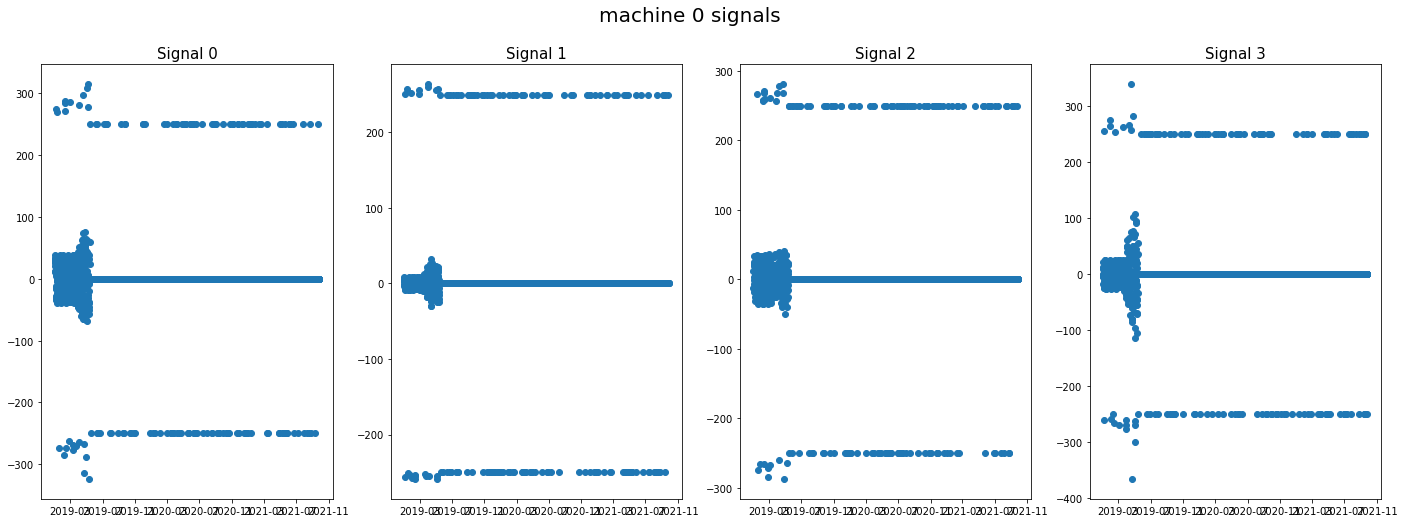

In [3]:
df0 = pd.read_csv('data/machine_0.csv', parse_dates=True, index_col=0)
fig, ax = plt.subplots(1,4, figsize=(24, 8))
fig.suptitle("machine 0 signals", size = 20)
for i in range (4):
    series = df0[str(i)]
    ax[i].plot(series, 'o')
    ax[i].set_title("Signal "+str(i), size = 15)
plt.show()

I spent some time just visualizing the data to begin with. We have 20 machines each with these signals over time. It's easier to see the noise looking at the values as individual points instead of a traced line over time. All machines have this noise for extreme values. First things first, let's get rid of it. We don't have to be too precise to filter out these values (greater than 200, less than -200) -- I said anything outside 3 standard deviations was an outlier which clearly captures these points.

By looking at the whole time series, we can clearly visualize the 'failed' state too (point when values go to 0). We know that the 'normal' and 'faulty' stages are somewhere in the early life of the machine. We'll zoom in on that section as well for 1 machine.


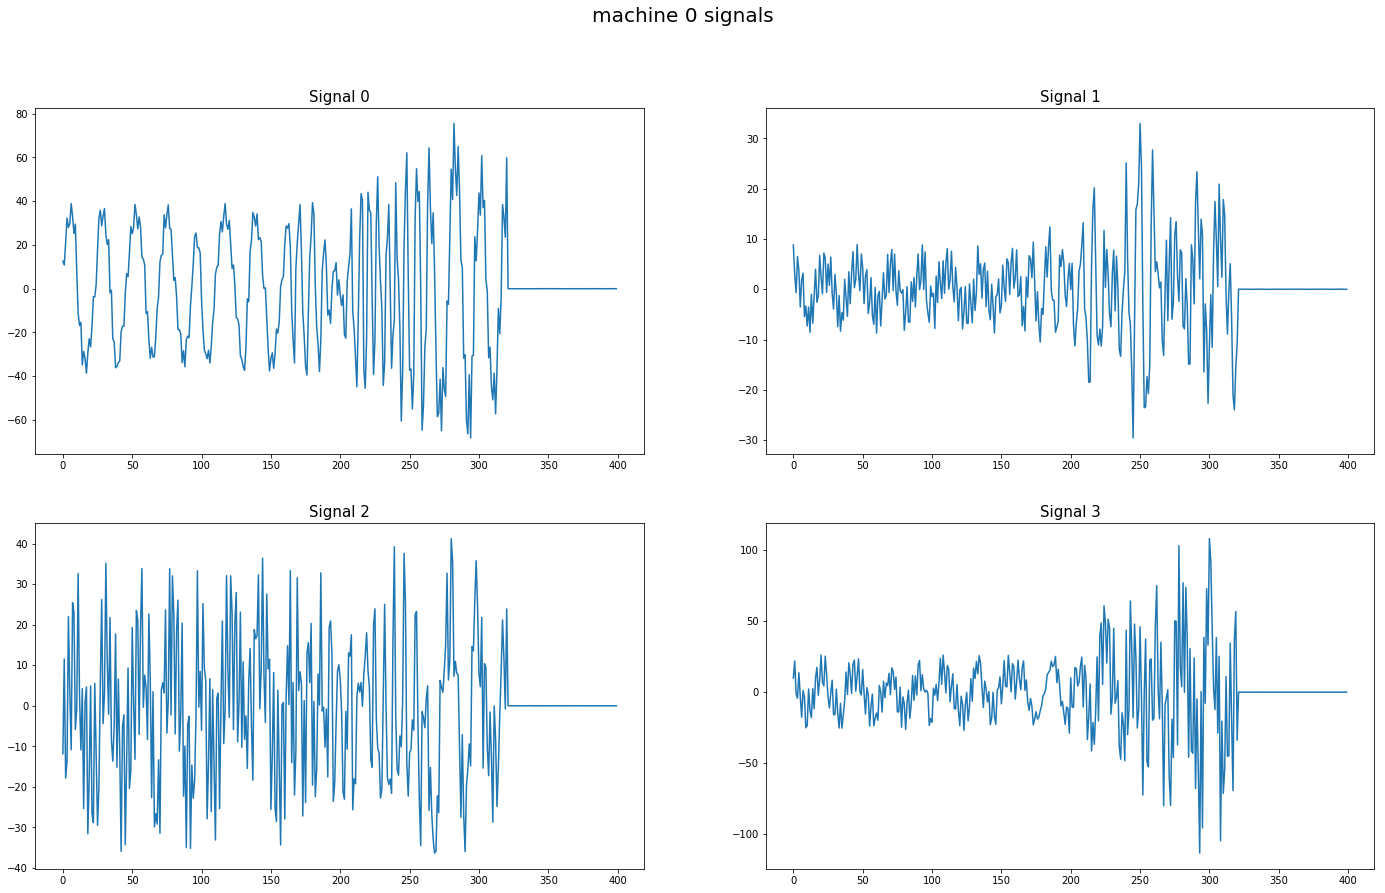

In [4]:
# remove outliers -- don't have to be too precise here the noise is clearly outside 3 stdevs
data0 = df0[(np.abs(stats.zscore(df0)) < 3).all(axis=1)]

plot_signals(data0, 0, zoom=400)

I'm only showing 1 example machine here, but these patterns generalize for all the machines (well, most of them -- we'll get back to that in a second). 

We can see that these signals follow a cyclical pattern (like a sin or cos function) for what I interpret as the 'normal' mode -- like the problem stated, this is the "fairly predictable way" the signals behave. We also can see more clearly when the machine enters the 'faulty' mode during which the signals appears "visibly quite different."

I noticed that the values in the faulty mode are visibly different and less predictable for 2 reasons: 

1. the range/spread of the values tends to get wider, and 

2. the frequency of these values gets wonky and leads to some slighty lower values right before the faulty stage (see signals 0 and 2 in particular).

### Removing machines 4 & 19

While I discovered these machines later in the process, I think it's appropriate to mention them in the 'data cleaning' section. For my approach, I make the assumption that the models are operating in a "normal" mode before the faulty mode. The data for these two machines appears to already be in the faulty mode. For this reason, I won't be considering them in my analysis. 

Here's what the signals look like for these two machines:

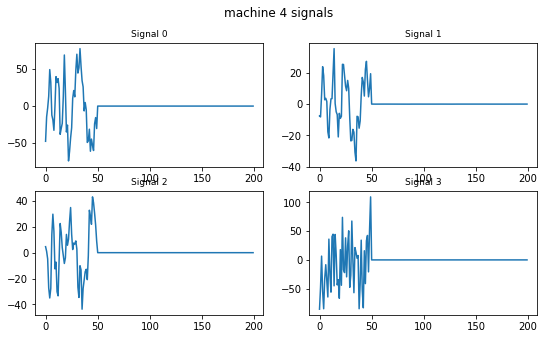

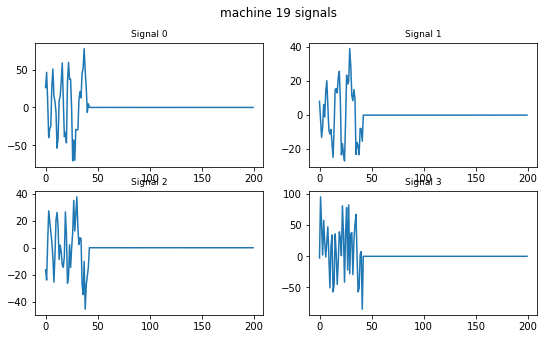

In [5]:
for num in [4,19]:
    df = pd.read_csv('data/machine_'+str(num)+'.csv', parse_dates=True, index_col=0)

    # remove outliers -- don't have to be too precise here the noise is clearly outside 3 stdevs
    data = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    
    plot_signals(data, num, zoom=200, small=True)
    
plt.show()

# My Approach

#### As outlined in the README, our goal is to predict the start of this 'faulty' stage, so that means alerting when the signals stop repeating in this "fairly predictable way."

I set out to simplify this problem into something I could work with better. To capture the two differences I noticed, I looked to transform and simplify the signals with summary statistics: a **rolling standard deviation** and a **rolling max value**. The rolling standard deviation (black line) and rolling max value (orange line) are computed over a 30 observation **lookback window**. I picked this value after tuning for it and trying different values. I wanted to capture a peak and valley of the cycle of the signal.

Because there are no labels for the stages, this problem seemed like one that should be solved with **unsupervised learning** so that a model can detect and *cluster* these differences.


We can see how this looks for the same machine here:

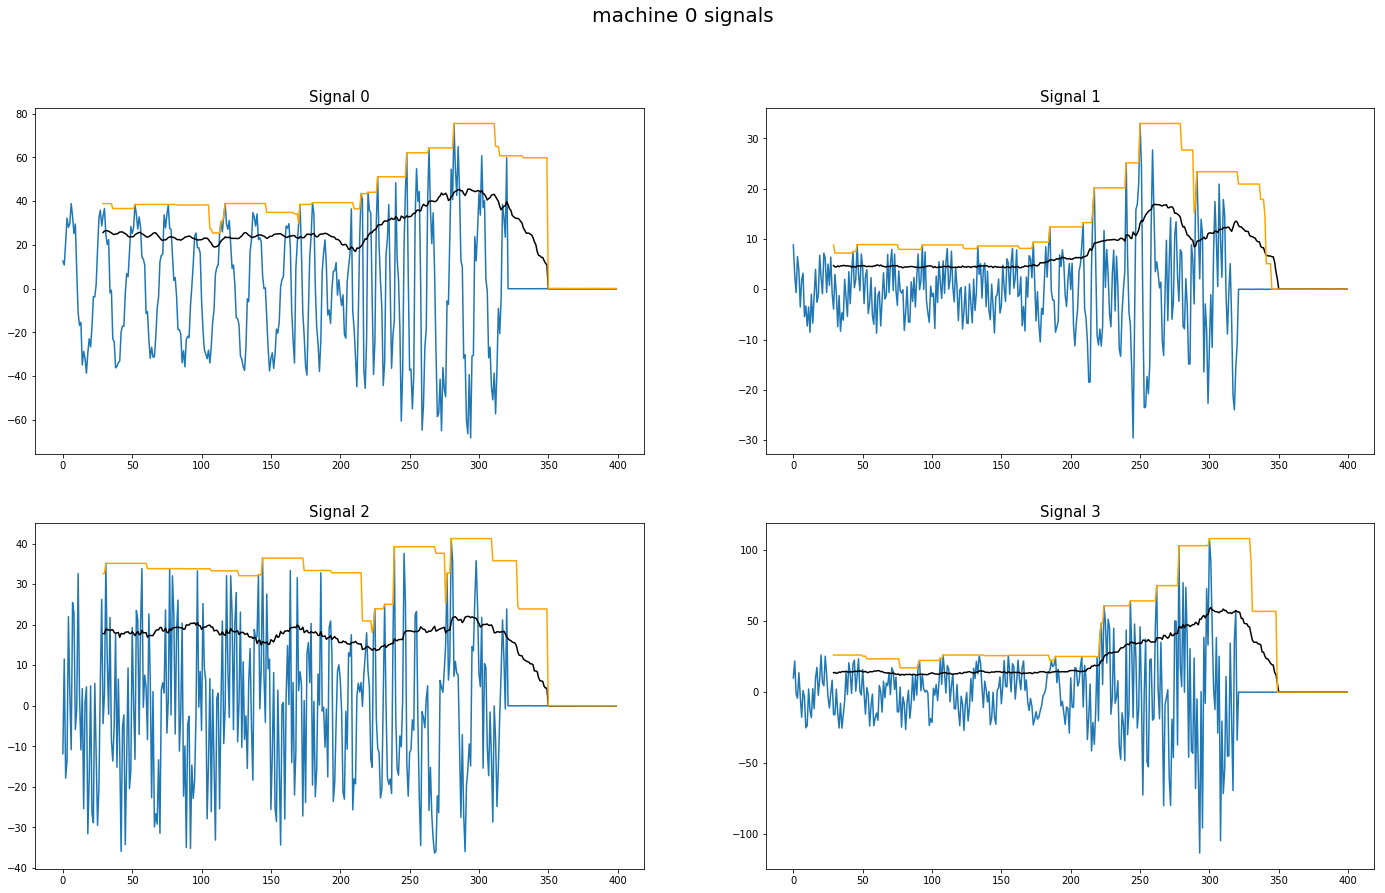

In [6]:
# still machine0
# orange line is rolling max, black line is rolling st dev -- both 30 observation lookback
plot_signals(data0, 0, zoom=400, features=True)

# Unsupervised Learning - K Means clustering

I started by testing my approach from a high-level. The original notebook said that we wanted to pinpoint the times of fault *and failure* in this machine. I decided to look at all the data and build a K Means model with 3 clusters to hopefully capture the differences in rolling max and standard deviation as they appear visually differently for the 3 phases.

In [7]:
output = []
for file in os.listdir("data/"):
    # skip machine 4 and 19
    if 'machine_4' in file or 'machine_19' in file:
        continue
    
    df = pd.read_csv('data/'+file, parse_dates=True, index_col=0)
    
    # remove outliers
    data = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    
    # calculate 2 summary statistics for each signal(4) -- 2*4 = 8 features
    final = dict()
    for i in range (4):
        series = data[str(i)]
        rolling_std = series.rolling(window=30).std()
        rolling_max = series.rolling(window=30).max()
        final['std_signal_'+str(i)] = rolling_std
        final['max_signal_'+str(i)] = rolling_max
        
    summary_stats = pd.DataFrame(final)
    summary_stats = summary_stats.dropna() # first 29 days don't have values with window=30
    X_std = StandardScaler().fit_transform(summary_stats) # standardize values before using kmeans
     
    km = KMeans(n_clusters=3)
    km.fit(X_std)
    all_predictions = km.predict(X_std)
    
    # Even with three clusters, sometimes these groups aren't linearly aligned. We want the indices for the 
    # breaks between the first and last groups. The model sometimes picks up weirrd differences inside of the
    # faulty group. We're just concerned with viewing this group as a whole
    start = all_predictions[0]
    clusters = []
    for i, val in enumerate(all_predictions):
        if val != start:
            clusters.append(i)
            start = val
    clusters.sort()
    faulty = clusters[0]
    failed = clusters[-1]
    
    # organize output into dataframe
    results = {
        'name': file.replace('.csv', ''),
        'faulty_index': faulty,
        'delta': failed - faulty
    }
    for i in range(4):
        results['faulty_std_'+str(i)] = final['std_signal_'+str(i)].iloc[faulty]
        results['faulty_max_'+str(i)] = final['max_signal_'+str(i)].iloc[faulty]
    output.append(results)

In [8]:
results = pd.DataFrame(output)
results.sort_values('name')

,delta,faulty_index,faulty_max_0,faulty_max_1,faulty_max_2,faulty_max_3,faulty_std_0,faulty_std_1,faulty_std_2,faulty_std_3,name
11,126,195,39.343620,12.389571,32.803958,25.155356,23.747510,6.266099,16.754747,14.356256,machine_0
14,105,1319,38.115884,15.689556,25.326260,28.832913,24.756791,6.514722,16.519137,14.456938,machine_1
13,12,167,36.725007,8.629142,36.440370,25.915328,23.068270,4.238134,18.434381,14.349502,machine_10
12,88,126,49.008095,11.023902,22.325490,26.178901,27.166608,7.721263,13.431354,19.725402,machine_11
8,79,453,40.130448,10.182435,33.750293,18.264614,22.156060,6.312640,16.875470,11.879266,machine_12
9,108,371,43.677322,10.319715,28.775595,24.398854,22.969089,5.718609,13.776082,13.705312,machine_13
1,144,190,36.572217,11.815440,29.938703,21.626649,23.704608,6.199179,16.873636,14.310131,machine_14
2,121,1333,40.349862,10.315749,29.576834,19.424068,23.693208,5.988121,17.110154,14.122583,machine_15
5,143,338,36.719396,11.110781,29.869142,22.310976,25.221762,6.140524,16.353006,13.309638,machine_16
4,63,491,36.806138,15.106195,29.670513,17.752522,23.932912,6.596868,17.866810,11.878695,machine_17


I don't want to take up too much space showing all the machines. But feel free to rerun this cell with other machines to check out how it worked. From a visual perspective, this method worked extremely well across all machines.

In [9]:
def predict_faulty_and_failure(number):
    df = pd.read_csv('data/machine_'+str(number)+'.csv', parse_dates=True, index_col=0)

    # remove outliers
    data = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

    # get row
    row = results[results.name=='machine_'+str(number)]

    plot_signals(data, number, small=True, features=True, zoom=int(row['faulty_index']+row['delta'])+50,
                 faulty=int(row['faulty_index']), failed=int(row['faulty_index']+row['delta']))    

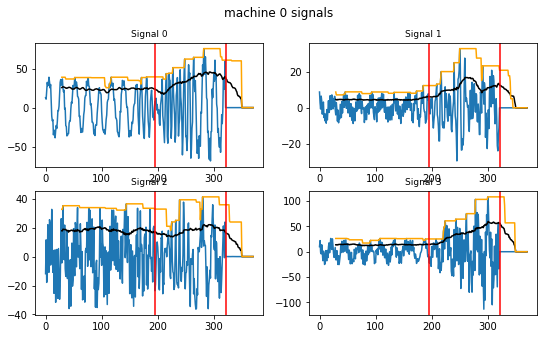

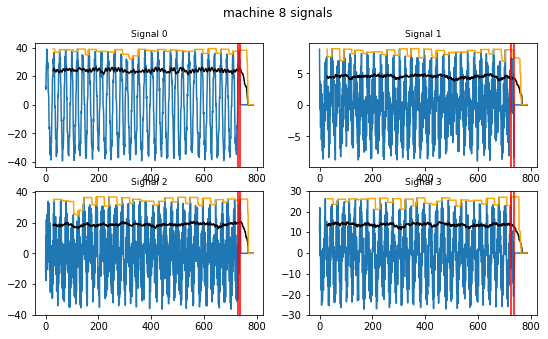

In [10]:
predict_faulty_and_failure(0)
predict_faulty_and_failure(8)

As we see from the dataframe above, k-means found extremely small delta values -- or the difference between the predicted faulty time and failed time -- for machines 3, 8, & 10. As we see from the graph above, it looks like that's actually the case: there really is no 'faulty' period in these examples -- just normal and failed. The k-means approach worked very well across all machines to find both break points by seeing all the data.

# Real-time Model

While it was nice to see that my approach made sense, we would not have access to that data in real life. In 'real-time', we instead would have to constantly update the predictions based on live values coming from the signals. This was what the original README was referring to I believe. So I used the same approach to go about predicting the start of the faulty stage.

For this case, however, I had to assume that we had some sort of data already acquired. By tuning the number of original observations, I found that this model works well with at least 120 observations to begin with. This allows enough time for the model to understand what the "normal" phase looks like and to identify any future anomolies. 

It works by iteratively taking on new values and recalculating a kmeans model with 2 clusters. The idea is that in the "normal" phase, the standard deviation and max values will not be different, so the model will find these groups randomly across the time series. However, as we take on values outside of this range (as indicated by the faulty phase), we will notice that the percent of smaller group will fall towards the end of the series (most recent observations/dates). By tuning this model, I found that this cluster usually makes up fewer than 30 observations. When this metric exceeds 95%, we say that it identifies the start of the faulty phase. In this way, the model will return the time it predicts for the beginning of the “faulty” period and gives the ExampleCo engineers as much time as possible to shut down their machines.

In [11]:
def live_model(number):
    df = pd.read_csv('data/machine_'+str(number)+'.csv', parse_dates=True, index_col=0)
    # remove outliers
    data = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

    final = dict()
    for i in range (4):
        series = data[str(i)]
        rolling_std = series.rolling(window=30).std()
        rolling_max = series.rolling(window=30).max()
        final['std_signal_'+str(i)] = rolling_std
        final['max_signal_'+str(i)] = rolling_max

    machine = pd.DataFrame(final)
    machine = machine.dropna()

    division = 120
    pct_of_smaller_group = 0
    while pct_of_smaller_group < 95:
        subset = machine[:division]
        X_std = StandardScaler().fit_transform(subset)

        km = KMeans(n_clusters=2)
        km.fit(X_std)
        preds = km.predict(X_std)

        unique, counts = np.unique(preds, return_counts=True)
        value_counts = dict(zip(unique, counts))
        
        # percent of smaller group that's in the last 30
        if value_counts[0] < value_counts[1]:
            # count 0's
            pct_of_smaller_group = ((30 - sum(preds[-30:])) / value_counts[0]) * 100
        else:
            # count 1's
            pct_of_smaller_group = (sum(preds[-30:]) / value_counts[1]) * 100

        if pct_of_smaller_group > 95:
            print("Alert: entering faulty stage")
            print("Date: "+str(machine.iloc[division].name))
            print("Division Index: "+str(division))
            print("Percent Score: "+str(pct_of_smaller_group))
            plot_signals(data, number, zoom=division+250, small=True, features=True, faulty=division)
#         else:
#             print("Still looking for faulty stage")
#             print("Division: "+str(division))
#             print(pct_of_smaller_group)

        division += 1

Alert: entering faulty stage
Date: 2019-03-25 00:39:51.197065689
Division Index: 174
Percent Score: 100.0


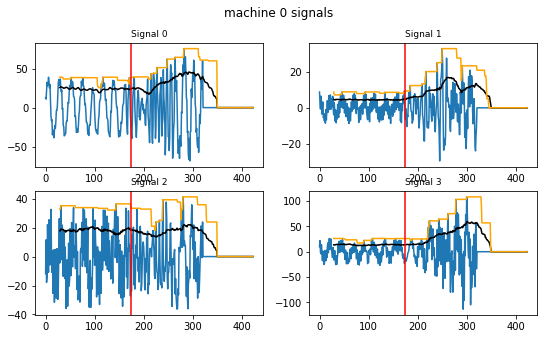

In [12]:
live_model(0)

# Efficacy Evaluation

I first tried the number of baseline observations at 100 and got 3 false positives (machines 8, 9 & 16). It led me to believe I needed more baseline values. However, with the baseline of 100 values, machine 11 does not work because the model with baseline 100 identified observation 100 as the faulty point. We will exclude machine 11 in the results below.

With a longer baseline with which the model can establish what's normal, the model performs extremely well -- and it recognizes the beginning of the faulty stage exactly right -- even earlier than the 3 cluster model from above in many cases.

If the executives at ExampleCo have the objective to err on the side on predicting that a machine is faulty even when it's not (to go and check the machine or something), we can use a baseline of 100 values (or perhaps less, I didn't have enough time to do a full analysis of the tradeoff between the type I error and number of previous observations), we can generate very reliable predictions with some false positives. However, if the goal is simply accuracy and we're given sufficient data (120 observation) for the machines, we are able to achieve 100% accuracy.

Check out the results from the real-time model:

Alert: entering faulty stage
Date: 2020-06-23 12:18:57.979326440
Division Index: 1297
Percent Score: 100.0


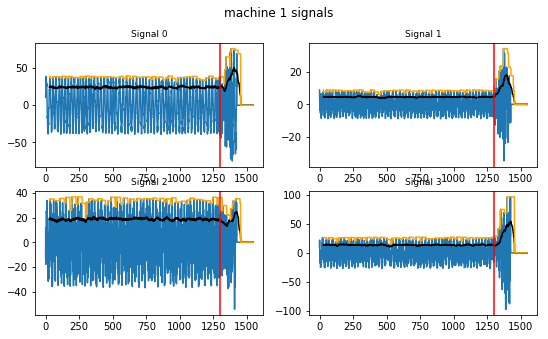

Alert: entering faulty stage
Date: 2020-08-07 20:40:44.014671560
Division Index: 1405
Percent Score: 100.0


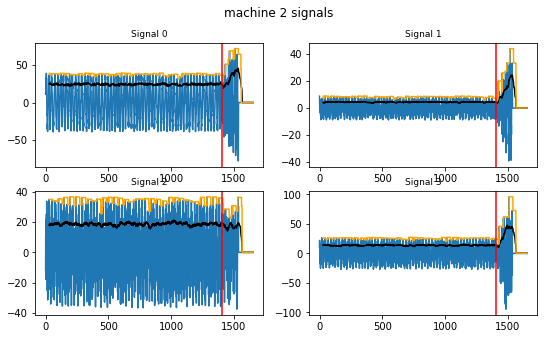

Alert: entering faulty stage
Date: 2019-03-18 00:36:29.529843281
Division Index: 155
Percent Score: 100.0


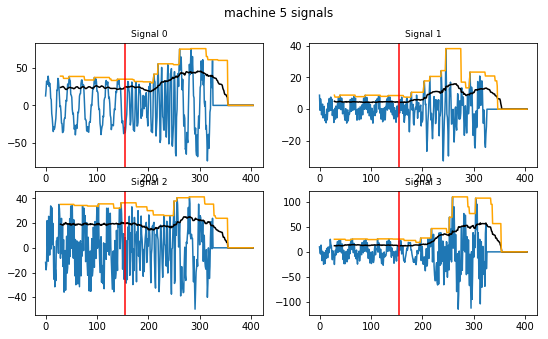

Alert: entering faulty stage
Date: 2019-05-26 09:09:46.995665222
Division Index: 311
Percent Score: 100.0


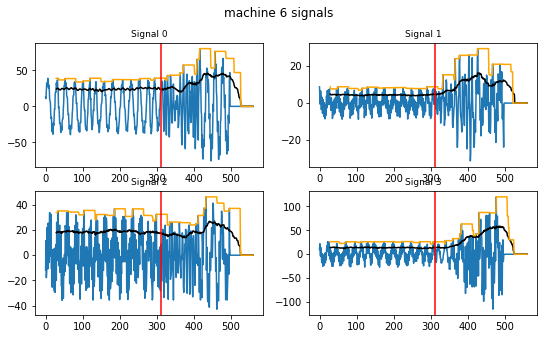

Alert: entering faulty stage
Date: 2020-03-09 03:27:54.558186064
Division Index: 1032
Percent Score: 100.0


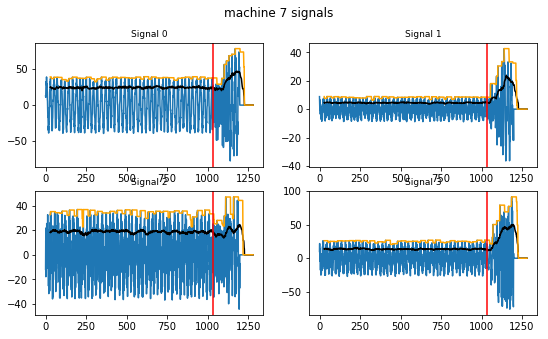

Alert: entering faulty stage
Date: 2019-11-02 10:26:36.532177392
Division Index: 728
Percent Score: 100.0


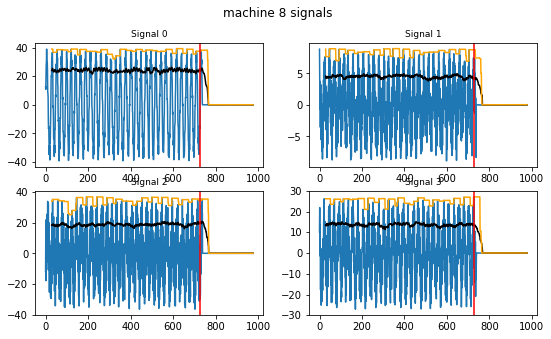

Alert: entering faulty stage
Date: 2019-08-05 09:43:52.477492500
Division Index: 504
Percent Score: 100.0


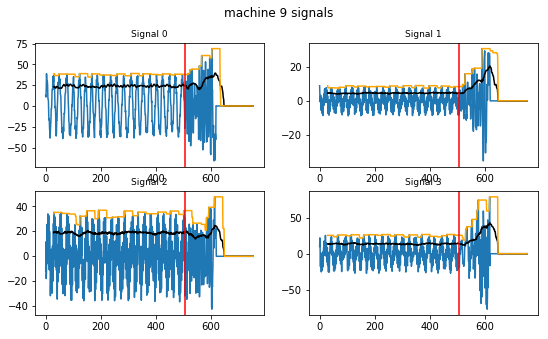

Alert: entering faulty stage
Date: 2019-03-19 00:36:58.339446482
Division Index: 163
Percent Score: 100.0


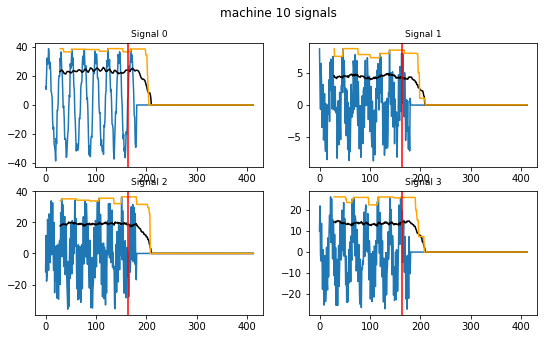

Alert: entering faulty stage
Date: 2019-07-04 09:28:30.570190064
Division Index: 419
Percent Score: 100.0


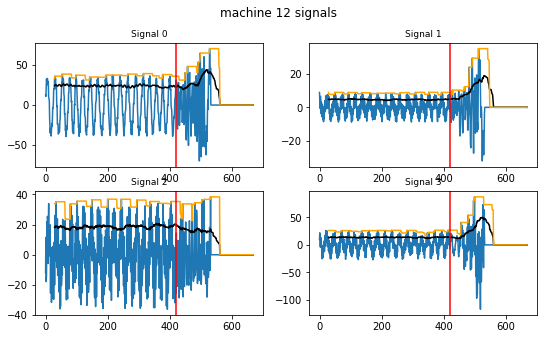

Alert: entering faulty stage
Date: 2019-05-28 17:10:54.218072692
Division Index: 333
Percent Score: 100.0


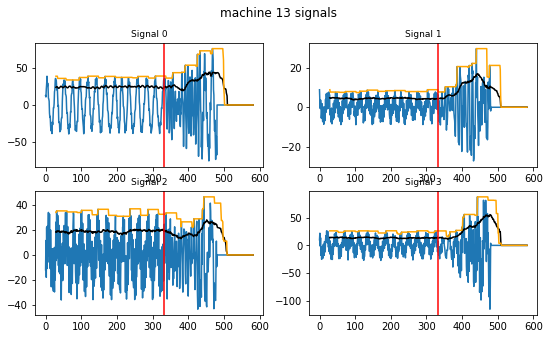

Alert: entering faulty stage
Date: 2019-03-23 00:38:53.577859287
Division Index: 169
Percent Score: 100.0


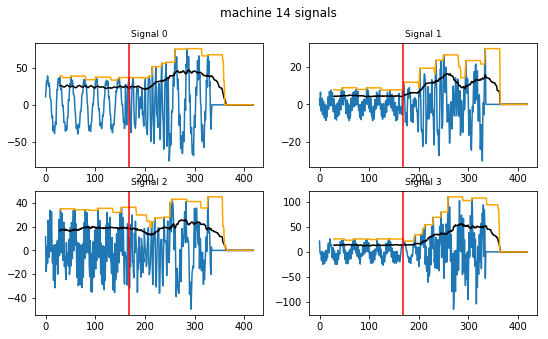

Alert: entering faulty stage
Date: 2020-07-11 20:27:46.155385128
Division Index: 1331
Percent Score: 100.0


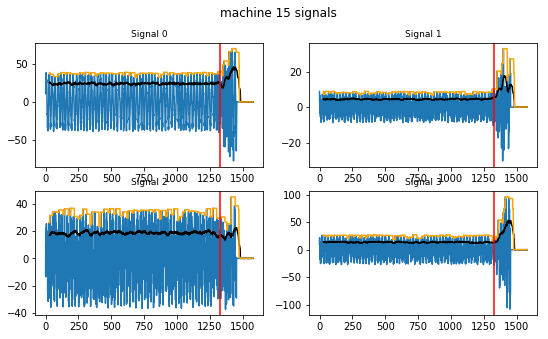

Alert: entering faulty stage
Date: 2019-05-23 17:08:30.170056686
Division Index: 317
Percent Score: 100.0


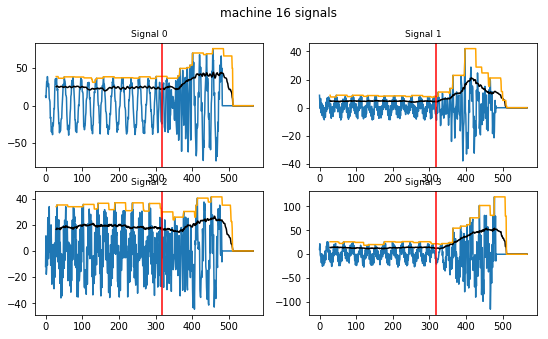

Alert: entering faulty stage
Date: 2019-07-25 01:38:25.968656220
Division Index: 465
Percent Score: 100.0


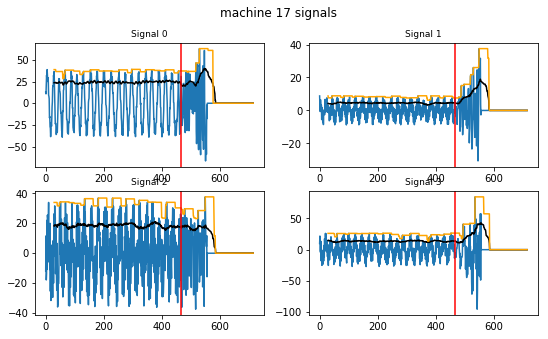

Alert: entering faulty stage
Date: 2019-03-23 16:39:12.784261421
Division Index: 182
Percent Score: 100.0


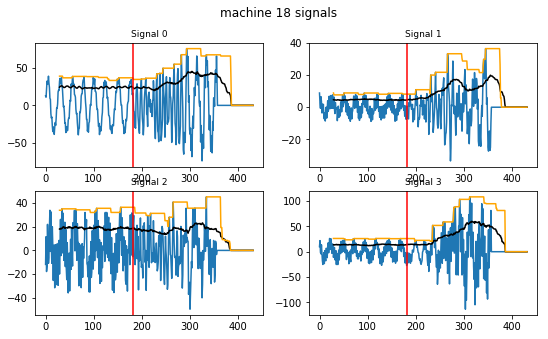

In [13]:
from itertools import chain
concatenated = chain(range(1,3), range(5, 11), range(12,19))
for i in concatenated:
    live_model(i)

# Limitations & Other Possibilities

As I mentioned throughout the analysis, my approach is dependent on the cyclical nature of the signals (so the lookback window would capture this cycle) and the difference between the general shapes of the "normal" and "faulty" stages. I believe this model balanced an appropriate degree of customization while still being robust for other machines. However, this approach may or may not generalize to machines with other patterns of signals -- we would have to look to see how we could capture the clusters as summary statistics. In addition, we may not know what the "faulty" stage looks like in a real life example.

Another limitation is that the model tends to perform better with the most amount of historical data as possible to build off of. For a more real-life ExampleCo, this could be a limitation depending on the length of the cycle time compared to the availibility/frequency of sensor data.

Given the time constraints of the assignment (I only had sunday to work on it with my schedule), I was not able to pursue other more advanced ML and deep learning techniques. I read a couple of papers regarding ARIMA time series forecasting and anomoly detection which seemed very appropriate for this situation. In addition, I would have liked to explore other clustering algorithms and neural networks. I'm not as familiar with all of these techniques, and I wish I had more time to understand the theory and code to apply to this challenge. 

I had a really good time hacking on this challenge today. It was actually super fun and far more enjoyable than the work I've done with my internship this summer. I feel like I learned a lot just today and would love to spend more time to advance my learning on some of these topics through an internship with TagUp. I appreciate the time you took looking over my code, and I look forward to hearing back from you about it soon.

Thanks!